In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from keras.applications import VGG19
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten , Dropout
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from google.colab import files
import shutil
import pickle

In [ ]:
# {"username":"miguelgallego","key":"6a7a2546d0b0a5683db1abd67fc0380c"}
dataset_link = "https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: miguelgallego
Your Kaggle Key: ··········


100%|██████████| 1.68G/1.68G [01:36<00:00, 18.7MB/s]


In [ ]:
# Carga el DataFrame desde el archivo CSV
balanced_data = pd.read_csv('balanced_data.csv')

In [ ]:
# Dividir los datos en entrenamiento (70%) y temporales (30%)
train_data, temp_data = train_test_split(balanced_data, test_size=0.3, random_state=42)

# Dividir los datos temporales en validación (50%) y prueba (50%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
import keras
# Crea y define el ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalizar los valores de píxeles al rango [0, 1]
    preprocessing_function=keras.applications.vgg19.preprocess_input # imagenes rgb a bgr
)

batch_size = 32

# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow_from_dataframe(
    dataframe = train_data,
    target_size=(200, 200),  # Ajusta el tamaño según tu modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = validation_data,
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de validación
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de prueba
)

images, img_labels = next(train_generator)
print("Forma del lote de imágenes:", images.shape)

Found 16650 validated image filenames belonging to 30 classes.
Found 3568 validated image filenames belonging to 30 classes.
Found 3568 validated image filenames belonging to 30 classes.
Forma del lote de imágenes: (32, 200, 200, 3)


Forma del lote de imágenes: (32, 200, 200, 3)


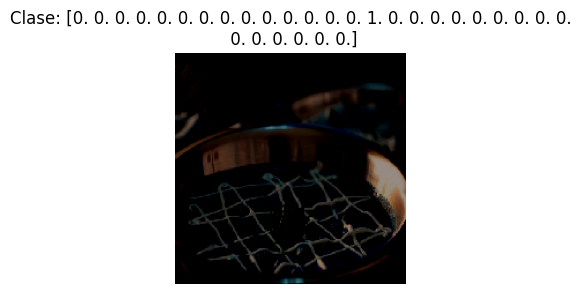

In [ ]:
# Tomar un lote de imágenes del generador
images, img_labels = next(train_generator)

# Verificar las formas de las imágenes en el lote
print("Forma del lote de imágenes:", images.shape)  # Debería ser (batch_size, height, width, channels)

# Seleccionar una imagen del lote (por ejemplo, la primera imagen)
image = images[0]  # Cambia el índice si se desea visualizar otra imagen

# Mostrar la imagen utilizando Matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(image.squeeze())  # Asegúrate de usar 'gray' para imágenes en escala de grises
plt.axis('off')  # Deshabilita los ejes
plt.title(f'Clase: {img_labels[0]}')  # Muestra la etiqueta de clase (cambia si no usas one-hot encoding)
plt.show()

In [ ]:
# Cargar y visualizar modelo preentrenado
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# Número de clases que serviran a la última capa de salida
classes_number = balanced_data['class'].value_counts().count()

# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Crear un modelo secuencial y agregar las capas personalizadas
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(classes_number, activation='softmax'))  # 30 clases en tu caso


In [ ]:
# Compila el modelo
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define una función de retorno de llamada para guardar el modelo en cada época
checkpoint = ModelCheckpoint(
    '200_model_tf',  # Nombre del archivo donde se guardarán los pesos del modelo
    monitor='val_accuracy',  # Métrica para monitorear (puede ser 'val_loss', 'val_accuracy', etc.)
    save_best_only=True,  # Solo guarda el modelo si la métrica mejora
    mode='max',  # 'max' para maximizar la métrica, 'min' para minimizar la métrica
    verbose=1  # Muestra un mensaje cuando se guarda el modelo
)

# Define una función de retorno de llamada para detener el entrenamiento si no hay mejoras
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Métrica para monitorear
    patience=5,  # Número de épocas sin mejora antes de detener el entrenamiento
    verbose=1,  # Muestra un mensaje cuando se detiene el entrenamiento
    mode='max'  # 'max' para maximizar la métrica, 'min' para minimizar la métrica
)

# Entrenar el modelo utilizando los generadores de datos
epochs = 50 # Número de épocas
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Número total de lotes por época
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Número total de lotes de validación por época
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
 67/520 [==>...........................] - ETA: 2:59 - loss: 3.4654 - accuracy: 0.0424

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 3.3177 - accuracy: 0.0789
Epoch 1: val_accuracy improved from -inf to 0.23508, saving model to 200_model_tf
520/520 [==============================] - 219s 410ms/step - loss: 3.3177 - accuracy: 0.0789 - val_loss: 3.0253 - val_accuracy: 0.2351
Epoch 2/50
446/520 [========================>.....] - ETA: 23s - loss: 2.9433 - accuracy: 0.1788

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 2.9008 - accuracy: 0.1902
Epoch 2: val_accuracy improved from 0.23508 to 0.45467, saving model to 200_model_tf
520/520 [==============================] - 202s 389ms/step - loss: 2.9008 - accuracy: 0.1902 - val_loss: 2.2948 - val_accuracy: 0.4547
Epoch 3/50
 90/520 [====>.........................] - ETA: 2:12 - loss: 2.5886 - accuracy: 0.2743

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 2.4383 - accuracy: 0.3077
Epoch 3: val_accuracy improved from 0.45467 to 0.57095, saving model to 200_model_tf
520/520 [==============================] - 202s 388ms/step - loss: 2.4383 - accuracy: 0.3077 - val_loss: 1.7947 - val_accuracy: 0.5709
Epoch 4/50
125/520 [======>.......................] - ETA: 2:01 - loss: 2.1983 - accuracy: 0.3695

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 2.0985 - accuracy: 0.3973
Epoch 4: val_accuracy improved from 0.57095 to 0.61120, saving model to 200_model_tf
520/520 [==============================] - 202s 388ms/step - loss: 2.0985 - accuracy: 0.3973 - val_loss: 1.4983 - val_accuracy: 0.6112
Epoch 5/50
306/520 [================>.............] - ETA: 1:07 - loss: 1.9185 - accuracy: 0.4394

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.8845 - accuracy: 0.4496
Epoch 5: val_accuracy improved from 0.61120 to 0.62979, saving model to 200_model_tf
520/520 [==============================] - 204s 393ms/step - loss: 1.8845 - accuracy: 0.4496 - val_loss: 1.3572 - val_accuracy: 0.6298
Epoch 6/50
109/520 [=====>........................] - ETA: 2:20 - loss: 1.7739 - accuracy: 0.4702

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.7271 - accuracy: 0.4841
Epoch 6: val_accuracy improved from 0.62979 to 0.65991, saving model to 200_model_tf
520/520 [==============================] - 204s 392ms/step - loss: 1.7271 - accuracy: 0.4841 - val_loss: 1.2655 - val_accuracy: 0.6599
Epoch 7/50
443/520 [========================>.....] - ETA: 25s - loss: 1.6082 - accuracy: 0.5137

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.5970 - accuracy: 0.5191
Epoch 7: val_accuracy improved from 0.65991 to 0.66273, saving model to 200_model_tf
520/520 [==============================] - 206s 396ms/step - loss: 1.5970 - accuracy: 0.5191 - val_loss: 1.1944 - val_accuracy: 0.6627
Epoch 8/50
519/520 [============================>.] - ETA: 0s - loss: 1.5020 - accuracy: 0.5483

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.5016 - accuracy: 0.5485
Epoch 8: val_accuracy improved from 0.66273 to 0.67708, saving model to 200_model_tf
520/520 [==============================] - 205s 394ms/step - loss: 1.5016 - accuracy: 0.5485 - val_loss: 1.1405 - val_accuracy: 0.6771
Epoch 9/50
334/520 [==================>...........] - ETA: 1:00 - loss: 1.4348 - accuracy: 0.5644

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.4240 - accuracy: 0.5687
Epoch 9: val_accuracy improved from 0.67708 to 0.69735, saving model to 200_model_tf
520/520 [==============================] - 205s 395ms/step - loss: 1.4240 - accuracy: 0.5687 - val_loss: 1.0796 - val_accuracy: 0.6974
Epoch 10/50
258/520 [=============>................] - ETA: 1:24 - loss: 1.3304 - accuracy: 0.5922

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.3416 - accuracy: 0.5881
Epoch 10: val_accuracy improved from 0.69735 to 0.70495, saving model to 200_model_tf
520/520 [==============================] - 204s 392ms/step - loss: 1.3416 - accuracy: 0.5881 - val_loss: 1.0605 - val_accuracy: 0.7050
Epoch 11/50
206/520 [==========>...................] - ETA: 1:39 - loss: 1.2739 - accuracy: 0.6124

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.6111
Epoch 11: val_accuracy improved from 0.70495 to 0.70890, saving model to 200_model_tf
520/520 [==============================] - 213s 410ms/step - loss: 1.2693 - accuracy: 0.6111 - val_loss: 1.0229 - val_accuracy: 0.7089
Epoch 12/50
410/520 [======================>.......] - ETA: 35s - loss: 1.2282 - accuracy: 0.6213

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.2248 - accuracy: 0.6211
Epoch 12: val_accuracy did not improve from 0.70890
520/520 [==============================] - 207s 399ms/step - loss: 1.2248 - accuracy: 0.6211 - val_loss: 1.0061 - val_accuracy: 0.7075
Epoch 13/50
520/520 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.6475
Epoch 13: val_accuracy improved from 0.70890 to 0.71565, saving model to 200_model_tf
520/520 [==============================] - 203s 391ms/step - loss: 1.1385 - accuracy: 0.6475 - val_loss: 1.0022 - val_accuracy: 0.7157
Epoch 14/50
 44/520 [=>............................] - ETA: 2:30 - loss: 1.0723 - accuracy: 0.6612

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.6556
Epoch 14: val_accuracy improved from 0.71565 to 0.72691, saving model to 200_model_tf
520/520 [==============================] - 199s 382ms/step - loss: 1.1002 - accuracy: 0.6556 - val_loss: 0.9806 - val_accuracy: 0.7269
Epoch 15/50
451/520 [=========================>....] - ETA: 21s - loss: 1.0403 - accuracy: 0.6748

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6732
Epoch 15: val_accuracy did not improve from 0.72691
520/520 [==============================] - 197s 379ms/step - loss: 1.0461 - accuracy: 0.6732 - val_loss: 0.9671 - val_accuracy: 0.7148
Epoch 16/50
520/520 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.6808
Epoch 16: val_accuracy improved from 0.72691 to 0.73114, saving model to 200_model_tf
520/520 [==============================] - 201s 386ms/step - loss: 1.0043 - accuracy: 0.6808 - val_loss: 0.9585 - val_accuracy: 0.7311
Epoch 17/50
473/520 [==========================>...] - ETA: 14s - loss: 0.9594 - accuracy: 0.7007

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.6971
Epoch 17: val_accuracy improved from 0.73114 to 0.73874, saving model to 200_model_tf
520/520 [==============================] - 202s 389ms/step - loss: 0.9677 - accuracy: 0.6971 - val_loss: 0.9404 - val_accuracy: 0.7387
Epoch 18/50
178/520 [=========>....................] - ETA: 1:42 - loss: 0.9105 - accuracy: 0.7066

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.9132 - accuracy: 0.7074
Epoch 18: val_accuracy did not improve from 0.73874
520/520 [==============================] - 205s 393ms/step - loss: 0.9132 - accuracy: 0.7074 - val_loss: 0.9378 - val_accuracy: 0.7370
Epoch 19/50
520/520 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.7151
Epoch 19: val_accuracy did not improve from 0.73874
520/520 [==============================] - 198s 381ms/step - loss: 0.8919 - accuracy: 0.7151 - val_loss: 0.9586 - val_accuracy: 0.7340
Epoch 20/50
520/520 [==============================] - ETA: 0s - loss: 0.8439 - accuracy: 0.7329
Epoch 20: val_accuracy improved from 0.73874 to 0.73958, saving model to 200_model_tf
520/520 [==============================] - 201s 386ms/step - loss: 0.8439 - accuracy: 0.7329 - val_loss: 0.9301 - val_accuracy: 0.7396
Epoch 21/50
453/520 [=========================>....] - ETA: 21s - loss: 0.8183 - accuracy: 0.7376

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.7401
Epoch 21: val_accuracy improved from 0.73958 to 0.74550, saving model to 200_model_tf
520/520 [==============================] - 201s 386ms/step - loss: 0.8135 - accuracy: 0.7401 - val_loss: 0.9270 - val_accuracy: 0.7455
Epoch 22/50
301/520 [================>.............] - ETA: 1:10 - loss: 0.7883 - accuracy: 0.7481

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.7829 - accuracy: 0.7468
Epoch 22: val_accuracy did not improve from 0.74550
520/520 [==============================] - 197s 380ms/step - loss: 0.7829 - accuracy: 0.7468 - val_loss: 0.9421 - val_accuracy: 0.7413
Epoch 23/50
520/520 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.7555
Epoch 23: val_accuracy improved from 0.74550 to 0.74634, saving model to 200_model_tf
520/520 [==============================] - 210s 404ms/step - loss: 0.7596 - accuracy: 0.7555 - val_loss: 0.9389 - val_accuracy: 0.7463
Epoch 24/50
416/520 [=======================>......] - ETA: 33s - loss: 0.7308 - accuracy: 0.7596

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.7574
Epoch 24: val_accuracy did not improve from 0.74634
520/520 [==============================] - 204s 392ms/step - loss: 0.7347 - accuracy: 0.7574 - val_loss: 0.9440 - val_accuracy: 0.7424
Epoch 25/50
520/520 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.7620
Epoch 25: val_accuracy did not improve from 0.74634
520/520 [==============================] - 202s 389ms/step - loss: 0.7236 - accuracy: 0.7620 - val_loss: 0.9686 - val_accuracy: 0.7385
Epoch 26/50
520/520 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7695
Epoch 26: val_accuracy improved from 0.74634 to 0.74747, saving model to 200_model_tf
520/520 [==============================] - 208s 399ms/step - loss: 0.7010 - accuracy: 0.7695 - val_loss: 0.9459 - val_accuracy: 0.7475
Epoch 27/50
 75/520 [===>..........................] - ETA: 2:34 - loss: 0.6631 - accuracy: 0.7788

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.7795
Epoch 27: val_accuracy did not improve from 0.74747
520/520 [==============================] - 201s 387ms/step - loss: 0.6795 - accuracy: 0.7795 - val_loss: 0.9683 - val_accuracy: 0.7424
Epoch 28/50
520/520 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7881
Epoch 28: val_accuracy did not improve from 0.74747
520/520 [==============================] - 203s 391ms/step - loss: 0.6605 - accuracy: 0.7881 - val_loss: 0.9262 - val_accuracy: 0.7475
Epoch 29/50
520/520 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.7947
Epoch 29: val_accuracy improved from 0.74747 to 0.75282, saving model to 200_model_tf
520/520 [==============================] - 206s 396ms/step - loss: 0.6359 - accuracy: 0.7947 - val_loss: 0.9399 - val_accuracy: 0.7528
Epoch 30/50
128/520 [======>.......................] - ETA: 2:11 - loss: 0.6149 - accuracy: 0.7917

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


520/520 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7955
Epoch 30: val_accuracy did not improve from 0.75282
520/520 [==============================] - 202s 388ms/step - loss: 0.6151 - accuracy: 0.7955 - val_loss: 0.9580 - val_accuracy: 0.7466
Epoch 31/50
520/520 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.8053
Epoch 31: val_accuracy did not improve from 0.75282
520/520 [==============================] - 199s 384ms/step - loss: 0.5974 - accuracy: 0.8053 - val_loss: 1.0108 - val_accuracy: 0.7373
Epoch 32/50
520/520 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.8089
Epoch 32: val_accuracy did not improve from 0.75282
520/520 [==============================] - 201s 386ms/step - loss: 0.5813 - accuracy: 0.8089 - val_loss: 0.9883 - val_accuracy: 0.7461
Epoch 33/50
520/520 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.8086
Epoch 33: val_accuracy did not improve from 0.75282
520/520 [==

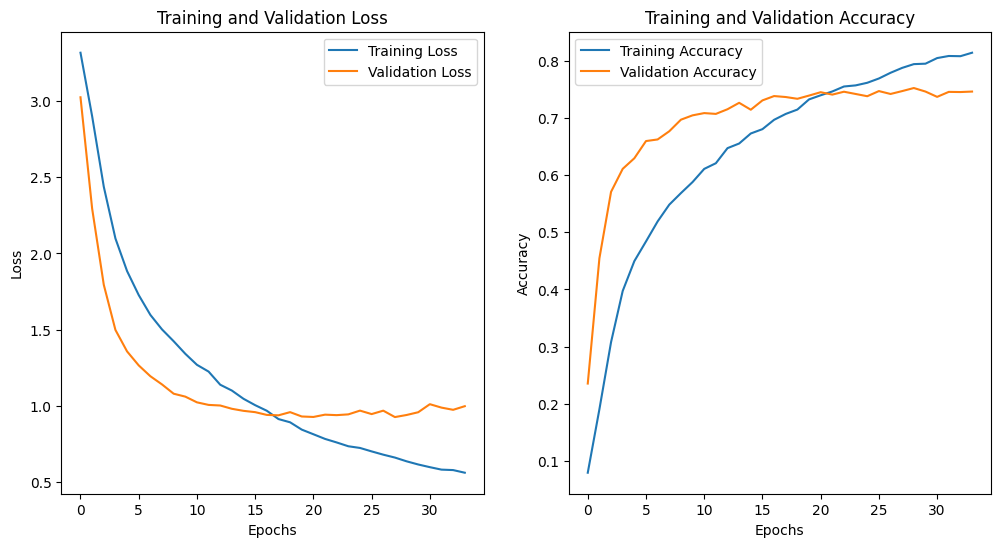

In [ ]:
# Obtener el historial de entrenamiento
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Trazar la pérdida de entrenamiento y validación.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Trazar la precisión del entrenamiento y la validación.
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Comprilir archivo para GCP
shutil.make_archive("32_200_model_tf", "zip", ".", "200_model_tf")

# Guardar historial del modelo
with open('32_200_history_checkpoint.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
# Descarga el modelo entrenado e histórico de entrenamiento
files.download('32_200_model_tf.zip')
files.download('32_200_history_checkpoint.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cargar el modelo
model_200 = load_model('/content/200_model_tf')

In [ ]:
# Obtiene perdida y precisión en el conjunto de prueba
test_loss, test_accuracy = model_200.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

112/112 [==============================] - 34s 302ms/step - loss: 0.9492 - accuracy: 0.7408
Pérdida en el conjunto de prueba: 0.9491809606552124
Precisión en el conjunto de prueba: 0.7407511472702026


112/112 [==============================] - 33s 293ms/step
Matriz de Confusión:
[[ 78   3   4   1   4   1   4   4   0   0   6   0   1   0   0   0   1   2
    0   0   1   1   0   0   0   4   0   0   2   0]
 [  4  60   0   2   1   4   1   5   0   0   0   1   0   1   3   0   0   6
    0   0   0   1   3   1   2   3   7   0   5   1]
 [  1   4  96   1   4   1   0   0   0   0   0   2   0   4   0   0   0   0
    8   2   0   0   0   0   0   1   0   0   2   4]
 [  2   1   1  94   4   6   1   2   0   0   0   0   1   1   1   0   0   0
    4   0   2   0   0   0   3   1   3   0   1   0]
 [  6   0   2   5  76   4   6   6   1   0   0   1   0   0   0   0   0   0
    0   0   0   1   0   0   0   2   0   0   0   3]
 [  2   2   2  11   1  86   3   4   1   2   1   0   1   3   0   1   0   0
    2   0   1   2   0   1   3   6   0   0   1   1]
 [ 11   2   3   4  12   3  44   8   0   0   1   0   0   1   0   1   0   2
    2   0   3   3   0   0   1   4   1   1   1   5]
 [  9   2   3   9   5   4   9  62   0   0   0 

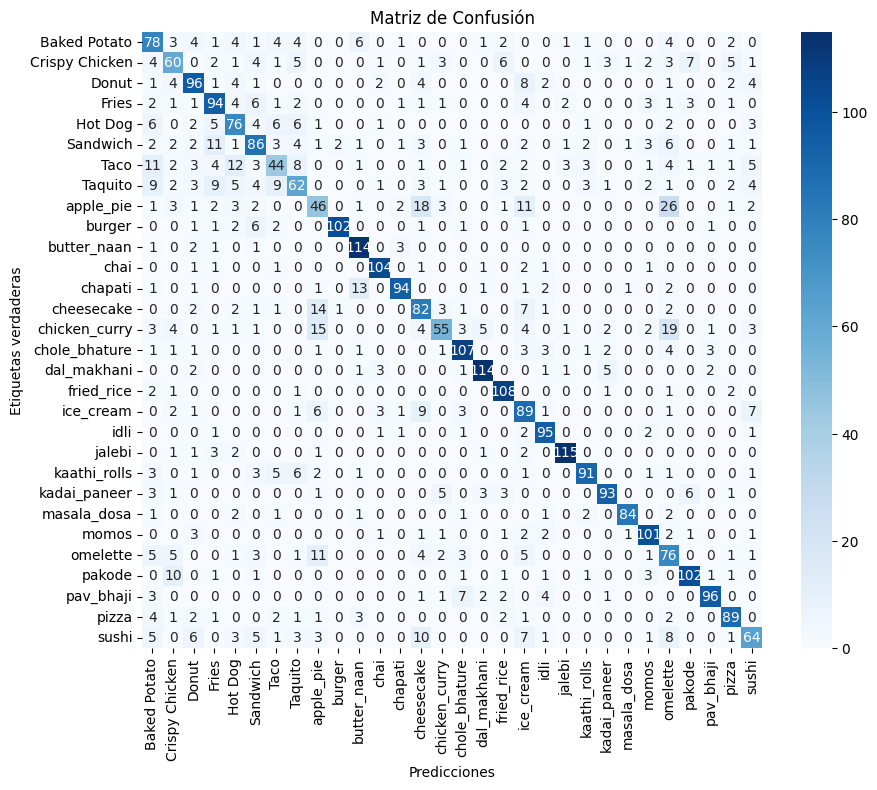

In [ ]:
# Predicciones del modelo en el conjunto de datos de prueba
predictions = model.predict(test_generator)
# Convierte las predicciones en etiquetas de clase (por ejemplo, utilizando np.argmax)
predicted_classes = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
true_classes = test_generator.classes
confusion = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(confusion)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Generar un informe de clasificación
class_labels = list(test_generator.class_indices.keys())
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Informe de Clasificación:\n", class_report)

Informe de Clasificación:
                 precision    recall  f1-score   support

  Baked Potato       0.53      0.67      0.59       117
Crispy Chicken       0.58      0.54      0.56       111
         Donut       0.71      0.74      0.72       130
         Fries       0.68      0.73      0.70       128
       Hot Dog       0.62      0.67      0.64       113
      Sandwich       0.65      0.63      0.64       137
          Taco       0.54      0.39      0.45       113
       Taquito       0.60      0.49      0.54       126
     apple_pie       0.44      0.37      0.41       123
        burger       0.97      0.86      0.91       118
   butter_naan       0.80      0.93      0.86       122
          chai       0.89      0.92      0.90       113
       chapati       0.90      0.80      0.85       117
    cheesecake       0.57      0.70      0.63       117
 chicken_curry       0.72      0.44      0.55       124
 chole_bhature       0.82      0.83      0.82       129
   dal_makhani      